# Assignment2  
# Multiclass perceptron  

# 1. Data processing
# Loading and flattening data and applying normalization

In [1]:
import numpy as np
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
class LoadSimpson:
    """here we create  an array of classes and then label them using the numbers 0-9 """
    
    def __init__(self, base_path):
        self.base_path = base_path
        self.classes = ['bart_simpson', 'charles_montgomery_burns', 'homer_simpson','krusty_the_clown', 'lisa_simpson', 'marge_simpson','milhouse_van_houten', 'moe_szyslak', 'ned_flanders','principal_skinner',]
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def load_dataset(self, image_type='grayscale', dataset_type='train'):
        images= []
        labels=[]
        dataset_path = os.path.join(self.base_path, image_type, dataset_type)

        for class_name in self.classes:
            class_path = os.path.join(dataset_path, class_name)

            if not os.path.exists(class_path):
                continue

            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg'))]
            for img_file in image_files:
                img_path = os.path.join(class_path, img_file)
                try:
                    img = Image.open(img_path)
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(self.class_to_idx[class_name])
                except Exception as e:
                    print(f"There was an error with the following image >>>{img_path}: {e}")
        return np.array(images), np.array(labels)

    def split(self, X, y, val_ratio=0.2, random_state=56):#HARDCODED SEED AND AN 80/20 SPLIT BETWEEN THE TRAINING SET AND VALIDATION SET
        """USED DEEPSEEK AI TO FIX A DATA SPLITTING ERROR """
        np.random.seed(random_state)
        X_train, X_val = [],[]
        y_train, y_val=[], []
        for class_idx in range(len(self.classes)):
            class_indices = np.where(y== class_idx)[0]

            if len(class_indices) > 0:
                np.random.shuffle(class_indices)
                val_size = int(len(class_indices) * val_ratio)

                val_indices = class_indices[:val_size]
                X_val.extend(X[val_indices])
                y_val.extend(y[val_indices])

                train_indices = class_indices[val_size:]
                X_train.extend(X[train_indices])
                y_train.extend(y[train_indices])
                
        X_train, X_val = np.array(X_train), np.array(X_val)
        y_train, y_val = np.array(y_train), np.array(y_val)

        train_shuffle =np.random.permutation(len(X_train))
        val_shuffle= np.random.permutation(len(X_val))

        return X_train[train_shuffle], X_val[val_shuffle], y_train[train_shuffle], y_val[val_shuffle]

    #Getting  the parameters for normalization from the training set only.
    def norm_params(self, X_train, norm_type):
        """
        normalizatig parameters from training data
        """
        X_flat = X_train.reshape(X_train.shape[0], -1) 
        
        if norm_type == 'none':
            return {}
        
        elif norm_type == 'normalization':
            min_vals = X_flat.min(axis=0)
            max_vals = X_flat.max(axis=0)
            
            range_vals = max_vals - min_vals
            range_vals[range_vals == 0] = 1  #using a mask to prevent zero devison
            
            params = {'min': min_vals,'max': max_vals,'range': range_vals}
        
        elif norm_type=='standardization':
            mean_vals = X_flat.mean(axis=0)
            std_vals = X_flat.std(axis=0)
            
            std_vals[std_vals == 0] = 1 #using a mask to prevent zero devison
            
            params = {'mean': mean_vals,'std': std_vals}
        return params

    def normalizer(self, X, normalization='normalization', norm_params=None):
        """
        Normalize data :
        if its training data:
            calculate the normalization paramenters
        else:
            use the pre computed normalization parameters from the training set
        """
        X_flat = X.reshape(X.shape[0], -1)
        
        if normalization == 'none':
            return X_flat
        
        elif normalization == 'normalization':
            if norm_params is None:
                min_vals = X_flat.min(axis=0)
                max_vals = X_flat.max(axis=0)
                range_vals=max_vals - min_vals
                range_vals[range_vals == 0] = 1
                X_normalized = (X_flat - min_vals) / range_vals
            else:
                X_normalized =(X_flat - norm_params['min']) / norm_params['range']
        
        elif normalization == 'standardization':
            if norm_params is None:
                mean_vals = X_flat.mean(axis=0)
                std_vals = X_flat.std(axis=0)
                std_vals[std_vals == 0] = 1
                X_normalized = (X_flat - mean_vals) / std_vals
            else:
                X_normalized = (X_flat - norm_params['mean']) / norm_params['std']
        
        return X_normalized

In [3]:
def image_loader():
    loader = LoadSimpson('./Simpsons MNIST')
    
    X_train_gray, y_train_gray = loader.load_dataset('grayscale', 'train')
    X_test_gray, y_test_gray = loader.load_dataset('grayscale', 'test')
    X_train_rgb, y_train_rgb =loader.load_dataset('rgb', 'train')
    X_test_rgb, y_test_rgb = loader.load_dataset('rgb', 'test')
    
    X_train_gray, X_val_gray, y_train_gray, y_val_gray = loader.split(X_train_gray, y_train_gray)#next splitting the current training data 
    X_train_rgb, X_val_rgb, y_train_rgb, y_val_rgb = loader.split(X_train_rgb, y_train_rgb)
     
    gray_norm_params = loader.norm_params(X_train_gray, 'normalization')
    rgb_norm_params=loader.norm_params(X_train_rgb, 'normalization')
   
    X_train_gray_processed = loader.normalizer(X_train_gray, 'normalization') #apply normalization strategy=0-1 normalization
    X_val_gray_processed = loader.normalizer(X_val_gray, 'normalization', gray_norm_params)
    X_test_gray_processed=loader.normalizer(X_test_gray, 'normalization', gray_norm_params)
    
    X_train_rgb_processed =loader.normalizer(X_train_rgb, 'normalization')
    X_val_rgb_processed =loader.normalizer(X_val_rgb, 'normalization', rgb_norm_params)
    X_test_rgb_processed=loader.normalizer(X_test_rgb, 'normalization', rgb_norm_params)
    
    return (X_train_gray_processed, X_val_gray_processed, X_test_gray_processed,
            X_train_rgb_processed, X_val_rgb_processed, X_test_rgb_processed,
            y_train_gray, y_val_gray, y_test_gray,
            y_train_rgb, y_val_rgb, y_test_rgb)

# 2. Multi-class perceptron implementation

# Binary class  
**In the BinaryPerceptron class I treated bias as a weight as well following the linear algebra notaion where b = w0**  
**This is done to make it so that the bias terms undergoes the same initialisation as all the weights**

In [4]:
class BinaryPerceptron:
    def __init__(self, n_inputs, learning_rate=0.01, init_strategy='uniform'):
        self.n_inputs = n_inputs
        self.learning_rate = learning_rate

       #treating bias as a weight as well following the linear algebra notaion where b = w0
        
        if init_strategy == 'zeros':
            weights_augmented = np.zeros(n_inputs + 1)
        elif init_strategy == 'uniform':
            weights_augmented = np.random.uniform(-0.01, 0.01, n_inputs + 1)
            
        elif init_strategy =='gaussian':
            weights_augmented = np.random.normal(0.0, 0.01, n_inputs + 1)

        self.weights = weights_augmented[:-1]#splitting the weights and the bias term apart again 
        self.bias = weights_augmented[-1]
            
        
    def predict(self, x):
        activation = np.dot(x, self.weights) + self.bias
        return 1 if activation >=0 else 0
        
    def update(self, x, y_true, y_pred):
        error = y_true - y_pred
        self.weights +=self.learning_rate * error*x
        self.bias +=self.learning_rate *error

# MulticlassPerceptron  
  
**0 to 1 normalization**  
**a learning rate of 0.01**  
**the intialisation strategy was kept as foolowing the uniform distrbution**  

In [5]:
class MultiClassPerceptron:
    def __init__(self, input_size, num_classes=10, learning_rate=0.1, init_strategy='uniform'):
        self.input_size = input_size
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.init_strategy = init_strategy
        
        self.perceptrons = [
            BinaryPerceptron(input_size, learning_rate, init_strategy)
            for _ in range(num_classes)
        ]
    
    def predict(self, x):
        scores = []
        for i in range(self.num_classes):
            activation = np.dot(x, self.perceptrons[i].weights) + self.perceptrons[i].bias
            scores.append(activation)
        return np.argmax(scores)

    """The tarining method allows for trying different stopping condition/criteria 
    the patience variable is for stopping after our patience (represented as an interger) has been exhausted
    """
    def train(self, X, y, X_val, y_val, max_epochs=100, early_stopping=False, patience=4,screen=True):
        history = {'train_acc': [], 'val_acc': [], 'epochs': []} 
        best_val_acc = 0
        no_improvement = 0
        
        for epoch in range(max_epochs):
            indices = np.random.permutation(len(X))
            X_shuffled, y_shuffled = X[indices], y[indices]
            #Per perceptron
            for i in range(self.num_classes):
                y_binary = np.where(y_shuffled == i, 1, 0)
                for j in range(len(X_shuffled)):
                    prediction = self.perceptrons[i].predict(X_shuffled[j])
                    self.perceptrons[i].update(X_shuffled[j], y_binary[j], prediction)
            
            train_acc = self.accuracy(X, y)#getting the accuracy for both the validation and training for vialisation so can see which stopping criterion is best 
            val_acc = self.accuracy(X_val, y_val)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['epochs'].append(epoch + 1)

            if screen:
                if epoch % 10 ==0:
                    print(f"Epoch {epoch}: Train={train_acc:.3f}, Val={val_acc:.3f}")
            
            #If early syopping is implemented
            if early_stopping:
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    no_improvement = 0
                else:
                    no_improvement += 1
                    
                if no_improvement >= patience:
                    if screen:
                        print(f"Early stopping happens at epoch >>>> {epoch+1}")
                        break
        
        return history
    
    def accuracy(self, X, y):
        correct = 0
        for i in range(len(X)):
            if self.predict(X[i]) ==y[i]:
                correct += 1
        return correct / len(X)
    
    def plot_training_history(self, history):#for visualising the pregress
        """Used deepseek ai for this plotting function"""
        plt.figure(figsize=(8, 6))
        plt.plot(history['epochs'], history['train_acc'], label='Training Accuracy', marker='*')
        plt.plot(history['epochs'], history['val_acc'], label='Validation Accuracy', marker='o',color='purple')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training History: training vs validation to check for over fitting')
        plt.legend()
        plt.grid(True)
        plt.show()

# 3. Training

# Trying different stopping condtions  for both the RGB and Grayscale
**a)Fixed Number of Epochs**  
**b)Early Stopping with Different Patience**  

In [6]:
def stopping_conditions(X_train, y_train, X_val, y_val):
    """Comparing the two different stopping conditions :max number of epochs and early stopping"""

    outcome = {}

    conditions=[{'name': '50 Fixed epochs', 'max_epochs': 50, 'early_stopping': False},#conditions to test out 
    {'name': '100 Fixed epochs', 'max_epochs': 100, 'early_stopping': False},
    {'name': '150 Fixed epochs', 'max_epochs': 150, 'early_stopping': False},
    {'name': 'Early stopping with a patience of 10', 'max_epochs': 100, 'early_stopping': True, 'patience': 10},
    {'name': 'Early stopping with a patience of 20', 'max_epochs': 100, 'early_stopping': True, 'patience': 20},{'name': 'Early stopping with a patience of 30', 'max_epochs': 100, 'early_stopping': True, 'patience': 30},]

    for condition in conditions:#looping through different conditions
        print(f"\n==== {condition['name']} ===")
        perceptron = MultiClassPerceptron(input_size=X_train.shape[1], learning_rate=0.4)

        trained = perceptron.train(X_train, y_train, X_val, y_val,max_epochs=condition['max_epochs'],early_stopping=condition['early_stopping'],patience=condition.get('patience', 4))#used chat gpt for debugging an error: I was passing the condtions to the train functions in a wrong way

        outcome[condition['name']]={'best_val_acc': max(trained['val_acc']),'epochs_trained': len(trained['val_acc']),'overfitting_gap': trained['train_acc'][-1] - trained['val_acc'][-1]}
        print(f"Best val: {max(trained['val_acc']):.3f}, Epochs: {len(trained['val_acc'])}, Overfitting Gap: {100*(trained['train_acc'][-1] - trained['val_acc'][-1])}")


In [7]:
data =image_loader()
print(f"\n====Stopping conditions for GRAYSCALE images ===")
stopping_conditions(data[0], data[6], data[1], data[7])

print(f"\n====Stopping conditions for RGB images ===")
stopping_conditions(data[3], data[9], data[4], data[10])


====Stopping conditions for GRAYSCALE images ===

==== 50 Fixed epochs ===
Epoch 0: Train=0.205, Val=0.177
Epoch 10: Train=0.398, Val=0.235
Epoch 20: Train=0.245, Val=0.150
Epoch 30: Train=0.328, Val=0.204
Epoch 40: Train=0.266, Val=0.188
Best val: 0.235, Epochs: 50, Overfitting Gap: 22.671875000000004

==== 100 Fixed epochs ===
Epoch 0: Train=0.186, Val=0.152
Epoch 10: Train=0.358, Val=0.219
Epoch 20: Train=0.337, Val=0.211
Epoch 30: Train=0.194, Val=0.142
Epoch 40: Train=0.365, Val=0.216
Epoch 50: Train=0.363, Val=0.216
Epoch 60: Train=0.430, Val=0.233
Epoch 70: Train=0.380, Val=0.220
Epoch 80: Train=0.379, Val=0.226
Epoch 90: Train=0.388, Val=0.221
Best val: 0.246, Epochs: 100, Overfitting Gap: 17.15625

==== 150 Fixed epochs ===
Epoch 0: Train=0.242, Val=0.186
Epoch 10: Train=0.264, Val=0.163
Epoch 20: Train=0.251, Val=0.181
Epoch 30: Train=0.444, Val=0.248
Epoch 40: Train=0.293, Val=0.184
Epoch 50: Train=0.326, Val=0.184
Epoch 60: Train=0.473, Val=0.244
Epoch 70: Train=0.302, Val

# The best conditions in each case:  
**These were chosen with the aim of minimising the overfitting while balancing it with a good accuracy in the validation set**  
  
**For the grayscale images the best conditions :==== Early stopping with a patience of 20 ===**  
**For the RGB images the best conditions : ==== Early stopping with a patience of 10 ===**  
**default maximum number of epochs =100 in both cases**  
    

=== Training GRAYSCALE Model ===
Epoch 0: Train=0.239, Val=0.194
Epoch 10: Train=0.325, Val=0.217
Epoch 20: Train=0.340, Val=0.209
Early stopping happens at epoch >>>> 29


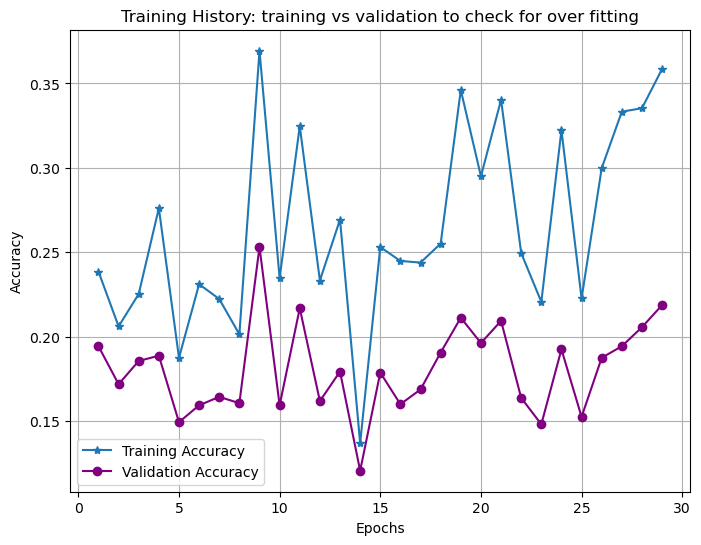


=== Training RGB Model ===
Epoch 0: Train=0.374, Val=0.330
Epoch 10: Train=0.390, Val=0.319
Epoch 20: Train=0.430, Val=0.292
Early stopping happens at epoch >>>> 26


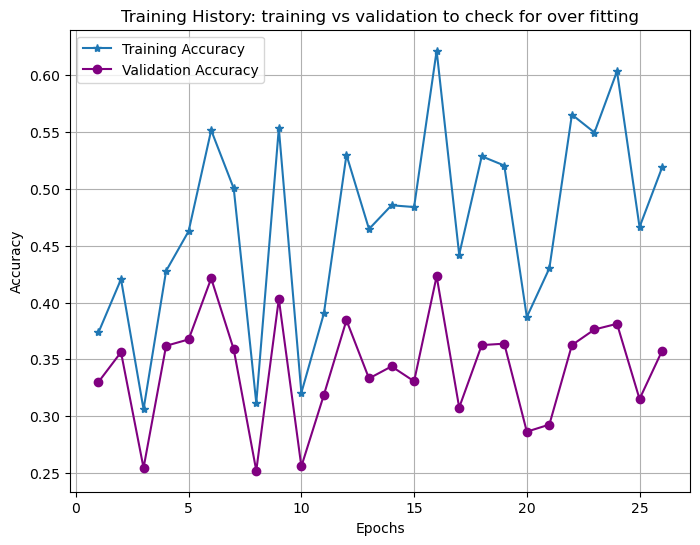

In [8]:
print("=== Training GRAYSCALE Model ===")
perceptron_gray = MultiClassPerceptron(input_size=data[0].shape[1], learning_rate=0.4)
history_gray = perceptron_gray.train(data[0], data[6], data[1], data[7],100,True,20)
perceptron_gray.plot_training_history(history_gray)

print("\n=== Training RGB Model ===")
perceptron_rgb = MultiClassPerceptron(input_size=data[3].shape[1], learning_rate=0.4)
history_rgb = perceptron_rgb.train(data[3], data[9], data[4], data[10], 100,True,10)
perceptron_rgb.plot_training_history(history_rgb)


# 4. Hyperparameter tuning

In [9]:
loader = LoadSimpson('./Simpsons MNIST')

In [10]:
def tuning(X_train, y_train, X_val, y_val,image_type):
    """Tuning the hyper parameters using the optimal conditions for both rgb and grayscale"""

    count=0
    models = {}  

    learning_rates = [0.2,0.5, 1.0]
    init_strategies = ['uniform', 'gaussian', 'zeros']
    normalizations = ['normalization', 'standardization', 'none']

    for rate in learning_rates:
        for init_strat in init_strategies:
            for norm_type in normalizations:
                count = count+1

                norm_params = loader.norm_params(X_train, norm_type)
                X_train_norm = loader.normalizer(X_train, norm_type)#normalize 
                X_val_norm = loader.normalizer(X_val, norm_type, norm_params)

                perceptron = MultiClassPerceptron(input_size=X_train_norm.shape[1], learning_rate=rate,init_strategy=init_strat)
                if image_type =='rgb':
                    history = perceptron.train(X_train_norm, y_train, X_val_norm, y_val,100,True,10,False)
                else:
                    history = perceptron.train(X_train_norm, y_train, X_val_norm, y_val,100,True,20,False)

                optimal_accuracy= max(history['val_acc'])
                key = f"learning_rate:{rate}_initilization_strategy:{init_strat}_normalization_type:{norm_type}"##KEY FOR IDENTIFYING THE MODEL ACCURACY AND PRINGING
                models[key] = optimal_accuracy #STORING THE MODELS SO WHEN CHOOSE LATER WHICH ONE HAS THE BIGGEST ACCURACY
                    
                print(f"Model{count} >>learning rate :{rate}, normalization: {norm_type}, intialization strategy: {init_strat} accuracy: {max(history['val_acc']):.3f}\n")
    return models
                
                

In [11]:
gray_results = tuning(data[0], data[6], data[1], data[7],'gray')

Model1 >>learning rate :0.2, normalization: normalization, intialization strategy: uniform accuracy: 0.246

Model2 >>learning rate :0.2, normalization: standardization, intialization strategy: uniform accuracy: 0.244

Model3 >>learning rate :0.2, normalization: none, intialization strategy: uniform accuracy: 0.247

Model4 >>learning rate :0.2, normalization: normalization, intialization strategy: gaussian accuracy: 0.247

Model5 >>learning rate :0.2, normalization: standardization, intialization strategy: gaussian accuracy: 0.244

Model6 >>learning rate :0.2, normalization: none, intialization strategy: gaussian accuracy: 0.246

Model7 >>learning rate :0.2, normalization: normalization, intialization strategy: zeros accuracy: 0.254

Model8 >>learning rate :0.2, normalization: standardization, intialization strategy: zeros accuracy: 0.243

Model9 >>learning rate :0.2, normalization: none, intialization strategy: zeros accuracy: 0.252

Model10 >>learning rate :0.5, normalization: normali

In [12]:
print("\n=== The best GRAYSCALE Model ===")
best_gray = max(gray_results.items(), key=lambda x: x[1])
print(f"The best GRAYSCALE model: {best_gray[0]} = {best_gray[1]:.3f}")


=== The best GRAYSCALE Model ===
The best GRAYSCALE model: learning_rate:1.0_initilization_strategy:gaussian_normalization_type:none = 0.263


In [13]:
rgb_result = tuning(data[3],data[9], data[4], data[10],'rgb')

Model1 >>learning rate :0.2, normalization: normalization, intialization strategy: uniform accuracy: 0.443

Model2 >>learning rate :0.2, normalization: standardization, intialization strategy: uniform accuracy: 0.391

Model3 >>learning rate :0.2, normalization: none, intialization strategy: uniform accuracy: 0.428

Model4 >>learning rate :0.2, normalization: normalization, intialization strategy: gaussian accuracy: 0.448

Model5 >>learning rate :0.2, normalization: standardization, intialization strategy: gaussian accuracy: 0.398

Model6 >>learning rate :0.2, normalization: none, intialization strategy: gaussian accuracy: 0.415

Model7 >>learning rate :0.2, normalization: normalization, intialization strategy: zeros accuracy: 0.410

Model8 >>learning rate :0.2, normalization: standardization, intialization strategy: zeros accuracy: 0.399

Model9 >>learning rate :0.2, normalization: none, intialization strategy: zeros accuracy: 0.429

Model10 >>learning rate :0.5, normalization: normali

In [14]:
print("\n=== The best RGB Model ===")
rgb = max(rgb_result.items(),key=lambda x: x[1])
print(f"The best RGB model: {rgb[0]} = {rgb[1]:.3f}")


=== The best RGB Model ===
The best RGB model: learning_rate:1.0_initilization_strategy:gaussian_normalization_type:normalization = 0.449


# 5. Evaluation

# One final training and the evaluate

In [15]:
#best models per image type

gray_rate = 1.0; gray_init = 'gaussian'; gray_norm = 'none'

rgb_rate = 1.0; rgb_init = 'gaussian'; rgb_norm = 'normalization '

# Train final GRAYSCALE model
X_train_gray_final = data[0]#since no normalization is required
X_test_gray_final = data[2]
X_val_gray_final = data[1]

norm_params_rgb = loader.norm_params(data[3], 'normalization')#apply 0-1 normalization
X_train_rgb_final = loader.normalizer(data[3], 'normalization')
X_val_rgb_final = loader.normalizer(data[4], 'normalization', norm_params_rgb)
X_test_rgb_final = loader.normalizer(data[5], 'normalization', norm_params_rgb)

print(">>>Training Final GRAYSCALE Model<<<")
perceptron_gray_final = MultiClassPerceptron(input_size=X_train_gray_final.shape[1], learning_rate=gray_rate, init_strategy=gray_init)

history_gray = perceptron_gray_final.train(X_train_gray_final, data[6], X_val_gray_final, data[7],max_epochs=100, early_stopping=True, patience=20)


print("\n>>>>Training Final RGB Model<<<<")
perceptron_rgb_final = MultiClassPerceptron(input_size=X_train_rgb_final.shape[1],learning_rate=rgb_rate, init_strategy=rgb_init)

history_rgb = perceptron_rgb_final.train(X_train_rgb_final, data[9],X_val_rgb_final, data[10], max_epochs=100, early_stopping=True, patience=10)


>>>Training Final GRAYSCALE Model<<<
Epoch 0: Train=0.159, Val=0.146
Epoch 10: Train=0.287, Val=0.184
Epoch 20: Train=0.337, Val=0.204
Early stopping happens at epoch >>>> 22

>>>>Training Final RGB Model<<<<
Epoch 0: Train=0.288, Val=0.279
Epoch 10: Train=0.628, Val=0.448
Epoch 20: Train=0.659, Val=0.432
Early stopping happens at epoch >>>> 21


In [16]:
def evaluation(perceptron, X_test, y_test, classes):
    y_hat = [] #prediction array
    for i in range(len(X_test)):
        y_hat.append(perceptron.predict(X_test[i]))
    
    # Convert to numpy arrays
    y_test = np.array(y_test)
    y_hat = np.array(y_hat)
    
    accuracy = accuracy_score(y_test, y_hat)
    precision = precision_score(y_test, y_hat, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_hat, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_hat, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_hat)
    
    class_metrics = {}#per class gathering the metrics
    for i, class_name in enumerate(classes):
        
        y_test_binary = (y_test == i).astype(int)# fROM boolean to integer FOR BINARY CLASSIFICATION
        y_hat_binary = (y_hat == i).astype(int)
        
        class_metrics[class_name] = {'precision': precision_score(y_test_binary, y_hat_binary, zero_division=0),'recall': recall_score(y_test_binary, y_hat_binary, zero_division=0),'f1': f1_score(y_test_binary, y_hat_binary, zero_division=0)}
    return accuracy, precision, recall, f1, cm, class_metrics, y_hat

In [17]:
gray_accuracy, gray_precision, gray_recall, gray_f1, gray_cm, gray_class_metrics, gray_pred = evaluation(perceptron_gray_final, X_test_gray_final, data[8], loader.classes) #GETTING THE GRAYSCLAE METRICS
rgb_accuracy, rgb_precision, rgb_recall, rgb_f1, rgb_cm, rgb_class_metrics, rgb_pred = evaluation(perceptron_rgb_final, X_test_rgb_final, data[11], loader.classes)#THE RGB METRICS

# fINAL METRICS

In [18]:
print(">>>>FINAL RESULTS (OVERALL)<<<")
print(f"\nGRAYSCALE Model:")
print(f"Accuracy:  {gray_accuracy:.3f}")
print(f"Precision: {gray_precision:.3f}")
print(f"Recall:    {gray_recall:.3f}") 
print(f"F1-score: {gray_f1:.3f}")

print(f"\nRGB Model:")
print(f"Accuracy:  {rgb_accuracy:.3f}")
print(f"Precision:{rgb_precision:.3f}")
print(f"Recall:    {rgb_recall:.3f}")
print(f"F1-score: {rgb_f1:.3f}")

print(f"\nRGB outperforms GRAYSCALE by: {(rgb_accuracy - gray_accuracy)*100:.3f}% accuracy")

>>>>FINAL RESULTS (OVERALL)<<<

GRAYSCALE Model:
Accuracy:  0.188
Precision: 0.269
Recall:    0.188
F1-score: 0.163

RGB Model:
Accuracy:  0.416
Precision:0.455
Recall:    0.416
F1-score: 0.415

RGB outperforms GRAYSCALE by: 22.900% accuracy


# PRINTING PER CLASS METRICS

In [19]:
print("\n>>>GRAYSCALE Per-Class Results<<<")
for character, metrics in gray_class_metrics.items():
    print(f"{character:25} Precision: {metrics['precision']:.3f}, Recall: {metrics['recall']:.3f}, F1: {metrics['f1']:.3f}")

print("\n>>>RGB Per-Class Results<<<")  
for character, metrics in rgb_class_metrics.items():
    print(f"{character:25} Precision: {metrics['precision']:.3f}, Recall: {metrics['recall']:.3f}, F1: {metrics['f1']:.3f}")


>>>GRAYSCALE Per-Class Results<<<
bart_simpson              Precision: 0.204, Recall: 0.150, F1: 0.173
charles_montgomery_burns  Precision: 0.383, Recall: 0.180, F1: 0.245
homer_simpson             Precision: 0.231, Recall: 0.105, F1: 0.144
krusty_the_clown          Precision: 0.342, Recall: 0.065, F1: 0.109
lisa_simpson              Precision: 0.250, Recall: 0.020, F1: 0.037
marge_simpson             Precision: 0.325, Recall: 0.065, F1: 0.108
milhouse_van_houten       Precision: 0.375, Recall: 0.090, F1: 0.145
moe_szyslak               Precision: 0.278, Recall: 0.175, F1: 0.215
ned_flanders              Precision: 0.167, Recall: 0.360, F1: 0.228
principal_skinner         Precision: 0.137, Recall: 0.665, F1: 0.228

>>>RGB Per-Class Results<<<
bart_simpson              Precision: 0.298, Recall: 0.180, F1: 0.224
charles_montgomery_burns  Precision: 0.458, Recall: 0.220, F1: 0.297
homer_simpson             Precision: 0.412, Recall: 0.315, F1: 0.357
krusty_the_clown          Precision: 0.

In [20]:
def confusion_matrix_plt(y_true, y_pred, classes, title):
    """Create confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    im = ax.imshow(cm, cmap='Oranges', interpolation='nearest')#utilizing imshow to create the visual heatmap
    
    cbar = ax.figure.colorbar(im, ax=ax)#color bar
    cbar.set_label('Number of Predictions', rotation=270, labelpad=20)
    
    ax.set_xticks(np.arange(len(classes)))#labels
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(len(classes)): #textual information
        for j in range(len(classes)):
            ax.text(j, i, str(cm[i, j]),
                   ha="center", va="center",
                   color="white" if cm[i, j] > cm.max()/2 else "black")
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('True Character/Class', fontsize=12)
    ax.set_xlabel('Predicted Character/Class', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return cm


>>>>GRAYSCALE Confusion Matrix<<<


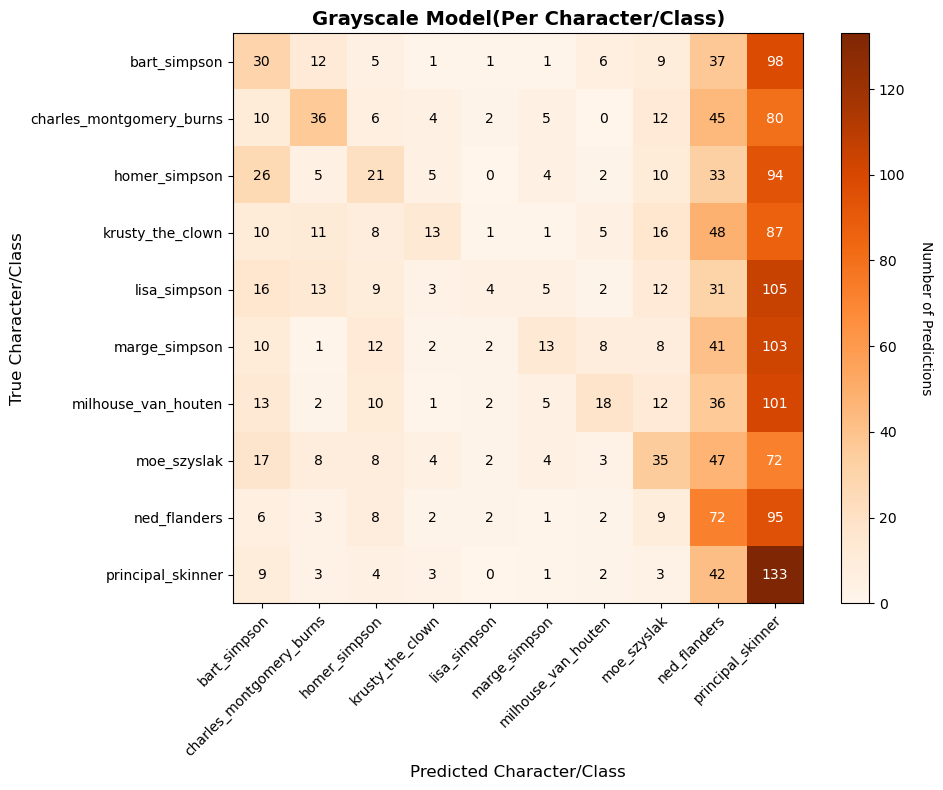

>>>>RGB Confusion Matrix<<<


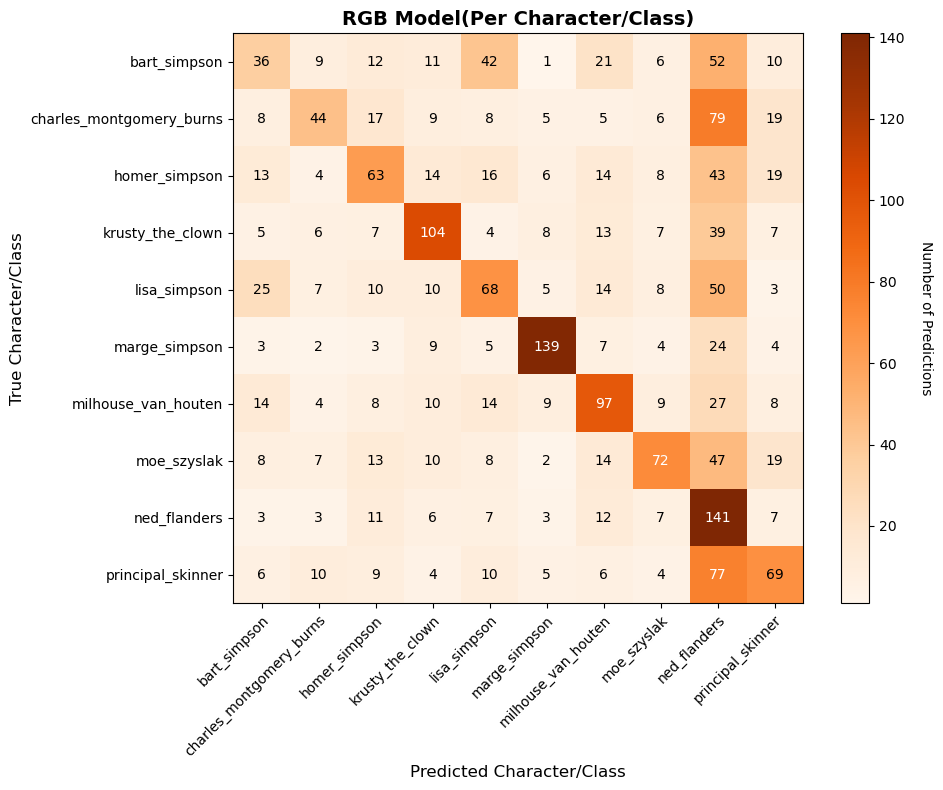

In [21]:
print(">>>>GRAYSCALE Confusion Matrix<<<")
gray_cm = confusion_matrix_plt(data[8], gray_pred, loader.classes,"Grayscale Model(Per Character/Class)")

print(">>>>RGB Confusion Matrix<<<")
rgb_cm = confusion_matrix_plt(data[11], rgb_pred, loader.classes,"RGB Model(Per Character/Class)")